In [156]:
%load_ext autoreload
%autoreload 2
import numpy as np
from helper_functions import *
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
path = "tweet_data/"

files = ["tweets_#gohawks.txt", "tweets_#gopatriots.txt", 
        "tweets_#nfl.txt", "tweets_#patriots.txt", 
        "tweets_#sb49.txt", "tweets_#superbowl.txt"]
tweets_gopatriots = load_tweets("tweet_data/tweets_#gopatriots.txt")
tweets_patriots = load_tweets("tweet_data/tweets_#patriots.txt")
tweets_gohawks = load_tweets("tweet_data/tweets_#gohawks.txt")
tweets_superbowl = load_tweets("tweet_data/tweets_#superbowl.txt")


In [140]:
tweets = tweets_gopatriots + tweets_gohawks + tweets_superbowl + tweets_patriots
print(len(tweets))
print(len(tweets_gopatriots))
print(len(tweets_gohawks))
print(len(tweets_superbowl))


24036
198
4228
16753


In [149]:
# print(tweets_gopatriots[0])
# print(tweets_gohawks[0])
# print(tweets_superbowl[0])

labels = list()
features = list()
for tweet in tweets:
    polarity = get_tweet_polarity(tweet['tweet']['text'])
    if polarity != 'Neutral':
        #labels.append(polarity)
        features.append(extract_features(tweet))


In [180]:
print(len(labels))
print(features)


0
[{'Timestamp': 24.0, 'Massachusetts': 1, 'Washington': 0, 'Retweet Count': 0, 'Tweet Polarity': 'Negative', 'Football Fan': 0, 'Score Diff': 0}, {'Timestamp': 26.0, 'Massachusetts': 1, 'Washington': 0, 'Retweet Count': 0, 'Tweet Polarity': 'Negative', 'Football Fan': 0, 'Score Diff': 0}, {'Timestamp': 515.0, 'Massachusetts': 0, 'Washington': 1, 'Retweet Count': 0, 'Tweet Polarity': 'Negative', 'Football Fan': 0, 'Score Diff': 0}, {'Timestamp': 515.0, 'Massachusetts': 1, 'Washington': 0, 'Retweet Count': 0, 'Tweet Polarity': 'Positive', 'Football Fan': 0, 'Score Diff': 0}, {'Timestamp': 758.0, 'Massachusetts': 1, 'Washington': 0, 'Retweet Count': 0, 'Tweet Polarity': 'Positive', 'Football Fan': 0, 'Score Diff': 0}, {'Timestamp': 855.0, 'Massachusetts': 0, 'Washington': 1, 'Retweet Count': 0, 'Tweet Polarity': 'Positive', 'Football Fan': 0, 'Score Diff': 0}, {'Timestamp': 1034.0, 'Massachusetts': 0, 'Washington': 1, 'Retweet Count': 0, 'Tweet Polarity': 'Positive', 'Football Fan': 0, '

In [219]:
# Convert features to numpy array
vec = DictVectorizer(sparse=False)
train_features = vec.fit_transform(features)
print(vec.feature_names_)

# Normalize columns of features with min-max scaler
scaler = MinMaxScaler(copy=False)
train_features = scaler.fit_transform(train_features)


print(train_features)

# Encode all labels
#le = LabelEncoder()
#le.fit(['Positive', 'Negative'])
#train_labels = le.transform(labels)
#print(train_labels)



['Football Fan', 'Massachusetts', 'Retweet Count', 'Score Diff', 'Timestamp', 'Tweet Polarity=Negative', 'Tweet Polarity=Positive', 'Washington']
[[ 0.  1.  0. ...,  1.  0.  0.]
 [ 0.  1.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  1.]
 ..., 
 [ 0.  1.  0. ...,  1.  0.  0.]
 [ 1.  0.  0. ...,  1.  0.  1.]
 [ 0.  1.  0. ...,  1.  0.  0.]]


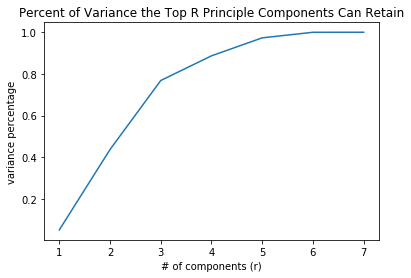

In [220]:
# Feature Dimension Reduction
svd = TruncatedSVD(n_components=7, random_state=42)


train_features = svd.fit_transform(train_features)
#plotting variance curve
plt.plot(range(1, 8), np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('# of components (r)')
plt.ylabel('variance percentage')
plt.title('Percent of Variance the Top R Principle Components Can Retain')
plt.show()


In [222]:
kmeans = KMeans(n_clusters=2, random_state=0)
labels_pred = kmeans.fit_predict(train_features[:, 0:5])
# print(kmeans.labels_)
print(kmeans.cluster_centers_)
print(labels_pred)

[[  1.39063592e+00  -4.85919534e-01   8.88856596e-02  -1.10316802e-02
    9.22430780e-04]
 [  1.16565815e+00   9.10644838e-01   5.44478450e-02  -1.48702685e-02
    1.14169535e-02]]
[1 1 0 ..., 1 0 1]


In [259]:
cluster0_mass_cnt = 0
cluster1_mass_cnt = 0
cluster0_wash_cnt = 0
cluster1_wash_cnt = 0

cluster0_last_2min_neg = 0
cluster1_last_2min_neg = 0
cluster0_last_2min_pos = 0
cluster1_last_2min_pos = 0

for sample, label_pred in zip(features, labels_pred):
    if sample['Massachusetts'] == 1 and label_pred == 0:
        cluster0_mass_cnt += 1

    elif sample['Massachusetts'] == 1 and label_pred == 1:
        cluster1_mass_cnt += 1

    elif sample['Washington'] == 1 and label_pred == 0:
        cluster0_wash_cnt += 1
    elif sample['Washington'] == 1 and label_pred == 1:
        cluster1_wash_cnt += 1
    else:
        pass
    
    if (sample['Timestamp'] >= 12660 and sample['Timestamp'] < 12900 and sample['Tweet Polarity'] == 'Negative'):
        if (label_pred == 0):
            cluster0_last_2min_neg += 1
        else:
            cluster1_last_2min_neg += 1
    elif (sample['Timestamp'] >= 12660 and  sample['Timestamp'] < 12900 and sample['Tweet Polarity'] == 'Positive'):
        if (label_pred == 0):
            cluster0_last_2min_pos += 1
        else:
            cluster1_last_2min_pos += 1
        
    
    
print(cluster0_mass_cnt)
print(cluster1_mass_cnt)
print(cluster0_wash_cnt)
print(cluster1_wash_cnt)
print(cluster0_last_2min_neg)
print(cluster1_last_2min_neg)
print(cluster0_last_2min_pos)
print(cluster1_last_2min_pos)


3
5471
8648
0
89
79
102
139


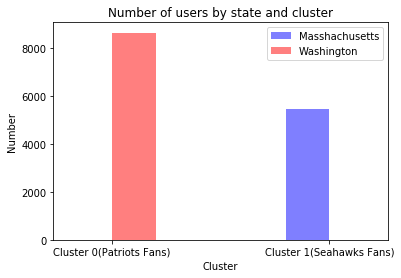

In [263]:
n_groups = 2
fig, ax = plt.subplots()
mass_cnt = (cluster0_mass_cnt, cluster1_mass_cnt)
wash_cnt = (cluster0_wash_cnt, cluster1_wash_cnt)
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.5


rects1 = ax.bar(index, mass_cnt, bar_width,
                alpha=opacity, color='b',
                label='Masshachusetts')

rects2 = ax.bar(index + bar_width, wash_cnt, bar_width,
                alpha=opacity, color='r',
                label='Washington')

ax.set_xlabel('Cluster')
ax.set_ylabel('Number')
ax.set_title('Number of users by state and cluster')

ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Cluster 0(Possibe Patriots Fans)', 'Cluster 1(Possible Seahawks Fans)'))

ax.legend()
plt.show()

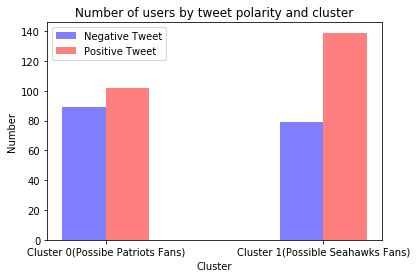

In [264]:
n_groups = 2
fig, ax = plt.subplots()

neg_cnt = (cluster0_last_2min_neg, cluster1_last_2min_neg)
pos_cnt = (cluster0_last_2min_pos, cluster1_last_2min_pos)
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.5

rects1 = ax.bar(index, neg_cnt, bar_width,
                alpha=opacity, color='b',
                label='Negative Tweet')

rects2 = ax.bar(index + bar_width, pos_cnt, bar_width,
                alpha=opacity, color='r',
                label='Positive Tweet')

ax.set_xlabel('Cluster')
ax.set_ylabel('Number')
ax.set_title('Number of users by tweet polarity and cluster')

ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Cluster 0(Possibe Patriots Fans)', 'Cluster 1(Possible Seahawks Fans)'))

ax.legend()
plt.show()

In [121]:
clf = SVC()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(train_features):
    X_train, X_test = train_features[train_index], train_features[test_index]
    y_train, y_test = train_labels[train_index], train_labels[test_index]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusionmatrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', confusionmatrix)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Micro F1 Score:', f1_score(y_test, y_pred, average='micro'))
    print('Macro F1 Score:', f1_score(y_test, y_pred, average='macro'))
    print('Weighted F1 Score:', f1_score(y_test, y_pred, average='weighted'))
    print('\n')



Confusion Matrix:
 [[  0 363]
 [  0 881]]
Accuracy: 0.708199356913
Micro F1 Score: 0.708199356913
Macro F1 Score: 0.414588235294
Weighted F1 Score: 0.587222243238




/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion Matrix:
 [[  0 387]
 [  0 857]]
Accuracy: 0.688906752412
Micro F1 Score: 0.688906752412
Macro F1 Score: 0.407900999524
Weighted F1 Score: 0.562011505775


Confusion Matrix:
 [[  0 393]
 [  0 851]]
Accuracy: 0.684083601286
Micro F1 Score: 0.684083601286
Macro F1 Score: 0.406205250597
Weighted F1 Score: 0.555756701379


Confusion Matrix:
 [[  0 354]
 [  0 890]]
Accuracy: 0.715434083601
Micro F1 Score: 0.715434083601
Macro F1 Score: 0.417057169634
Weighted F1 Score: 0.596753827934


Confusion Matrix:
 [[  0 399]
 [  0 844]]
Accuracy: 0.679002413516
Micro F1 Score: 0.679002413516
Macro F1 Score: 0.404408241495
Weighted F1 Score: 0.549188344041


Confusion Matrix:
 [[  0 370]
 [  0 873]]
Accuracy: 0.702333065165
Micro F1 Score: 0.702333065165
Macro F1 Score: 0.412570888469
Weighted F1 Score: 0.579524353392


Confusion Matrix:
 [[  0 392]
 [  0 851]]
Accuracy: 0.684633950121
Micro F1 Score: 0.684633950121
Macro F1 Score: 0.406399235912
Weighted F1 Score: 0.556469428417


Confusion 

In [124]:
clf = GaussianNB()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(train_features):
    X_train, X_test = train_features[train_index], train_features[test_index]
    y_train, y_test = train_labels[train_index], train_labels[test_index]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusionmatrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', confusionmatrix)
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Micro F1 Score:', f1_score(y_test, y_pred, average='micro'))
    print('Macro F1 Score:', f1_score(y_test, y_pred, average='macro'))
    print('Weighted F1 Score:', f1_score(y_test, y_pred, average='weighted'))
    print('\n')

Confusion Matrix:
 [[  0 363]
 [  0 881]]
Accuracy: 0.708199356913
Micro F1 Score: 0.708199356913
Macro F1 Score: 0.414588235294
Weighted F1 Score: 0.587222243238


Confusion Matrix:
 [[  0 387]
 [  0 857]]
Accuracy: 0.688906752412
Micro F1 Score: 0.688906752412
Macro F1 Score: 0.407900999524
Weighted F1 Score: 0.562011505775


Confusion Matrix:
 [[  0 393]
 [  0 851]]
Accuracy: 0.684083601286
Micro F1 Score: 0.684083601286
Macro F1 Score: 0.406205250597
Weighted F1 Score: 0.555756701379


Confusion Matrix:
 [[  0 354]
 [  0 890]]
Accuracy: 0.715434083601
Micro F1 Score: 0.715434083601
Macro F1 Score: 0.417057169634
Weighted F1 Score: 0.596753827934


Confusion Matrix:
 [[  0 399]
 [  0 844]]
Accuracy: 0.679002413516
Micro F1 Score: 0.679002413516
Macro F1 Score: 0.404408241495
Weighted F1 Score: 0.549188344041


Confusion Matrix:
 [[  0 370]
 [  0 873]]
Accuracy: 0.702333065165
Micro F1 Score: 0.702333065165
Macro F1 Score: 0.412570888469
Weighted F1 Score: 0.579524353392


Confusion 

/Users/zxxia/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [171]:
GAME_OVER_TIME - KICK_OFF_TIME - 300


12660